# Memory Based Classification with KDM

A memory based classifier with  [Kernel Density Matrices](https://github.com/fagonzalezo/kdm).

In [1]:
'''
Create a 2 moons dataset 
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Create a 2 moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_68572/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


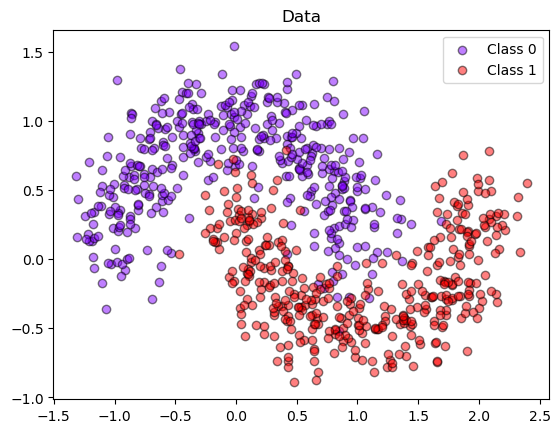

In [2]:
# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    CS = plt.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")

def gen_pred_fun_mem(clf):
    def pred_fun(X):
        X_ds = clf.create_predict_ds(X)
        return clf.predict(X_ds)[:, 1]
    return pred_fun

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

plot_data(X_train, y_train)

In [3]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras_core as keras
from keras_core.layers import Input, Dense
from keras_core.models import Model
from keras_core import optimizers
from keras_core import losses
from keras_core import metrics

import kdm


Using PyTorch backend.


## Memory KDM Model

First we pretrain a KDM Model for a few epochs and use the learned encoder for a Memory Based KDM Classifier.

In [4]:
from kdm.models import MemKDMClassModel, KDMClassModel


encoded_size = 10
dim_y = 2
encoder = keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=(2,)),
    keras.layers.Dense(encoded_size, activation='linear', input_shape=(2,)),
])  
n_comp = 20

kdm_model = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=1.)

kdm_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_model.init_components(X_train[idx], 
                          np.eye(2)[y_train[idx]],
                          init_sigma=True)
print(f"Initial sigma: {kdm_model.kernel.sigma.numpy()}")
kdm_model.fit(X_train, y_train, epochs=2, batch_size=32)
print(f"FInal sigma: {kdm_model.kernel.sigma.numpy()}")


Initial sigma: 1.07021963596344
Epoch 1/2
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4302 - sparse_categorical_accuracy: 0.8438

/Users/fgonza/miniforge3/envs/tf2/lib/python3.11/site-packages/keras_core/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4532 - sparse_categorical_accuracy: 0.8316        
Epoch 2/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3836 - sparse_categorical_accuracy: 0.8585       
FInal sigma: 1.0265774726867676


We evaluate the performance of the classifier on the test set.

In [5]:
score = kdm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = kdm_model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Test loss: 0.3294854164123535
Test accuracy: 0.8600000143051147
Train loss: 0.3352716565132141
Train accuracy: 0.8725000023841858


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step    
0.021446656 0.021446656


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_68572/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


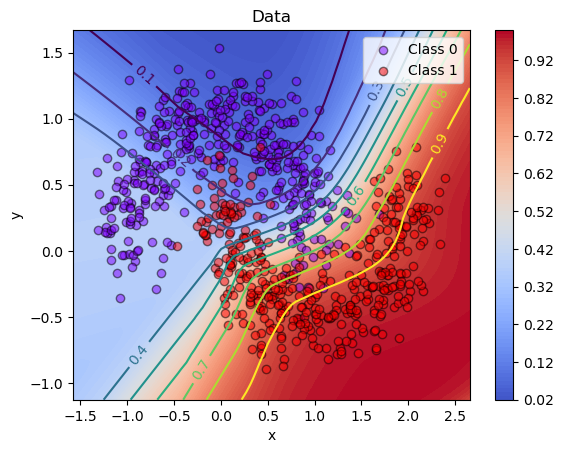

In [6]:
plot_decision_region(X, gen_pred_fun(kdm_model))
plot_data(X_train, y_train)


Since the model is trained for few epochs, the performance is not very good. Now we use the same encoder with a Memory Based KDM Classifier.

In [7]:
from kdm.models import MemKDMClassModel, KDMClassModel


encoded_size = 10
dim_y = 2
n_comp = 50

mkdm_model = MemKDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=kdm_model.kernel.sigma.numpy())

# init the memory
mkdm_model.create_index(X_train, np.eye(dim_y)[y_train])
X_train_ds = mkdm_model.create_train_ds(batch_size=32)
X_test_ds = mkdm_model.create_test_ds(X_test, np.eye(dim_y)[y_test], batch_size=32)
X_pred_ds = mkdm_model.create_predict_ds(X_test)

# train the classifier
mkdm_model.compile(optimizer=optimizers.SGD(learning_rate=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])
print(f"Initial sigma: {mkdm_model.kernel.sigma.numpy()}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step      
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/fgonza/miniforge3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_68572/2538497308.py", line 17, in <module>
    X_test_ds = mkdm_model.create_test_ds(X_test, np.eye(dim_y)[y_test], batch_size=32)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/fgonza/Documents/research/code/kdm/kdm/models/mem_kdm_class_model.py", line 80, in create_test_ds
    map(tf_search).
    ^^^^^^^^^^^^^^
  File "/Users/fgonza/miniforge3/envs/tf2/lib/python3.11/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 2278, in map
    return map_op._map_v2(
           ^^^^^^^^^^^^^^^
  File "/Users/fgonza/miniforge3/envs/tf2/lib/python3.11/site-packages/tensorflow/python/data/ops/map_op.py", line 37, in _map_v2
    return _MapDataset(
   

In [24]:
keras.config.disable_traceback_filtering()
mkdm_model.samples_y.shape


TensorShape([800, 2])

In [25]:
test1_ds = next(iter(X_train_ds))
test1_ds[0][0].shape, test1_ds[1].shape
test1_ds

2023-09-01 19:10:16.430356: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


((<tf.Tensor: shape=(32, 10), dtype=float32, numpy=
  array([[-1.79840043e-01, -5.97545564e-01, -2.91852772e-01,
           1.63120776e-01, -3.07733417e-01, -4.95919019e-01,
          -9.65580046e-02, -9.06456932e-02, -1.64119989e-01,
          -3.10051292e-01],
         [-5.59752360e-02, -2.41814494e-01, -1.07039750e-01,
           7.23820701e-02, -1.29043102e-01, -2.02932164e-01,
          -6.51382506e-02, -6.71765953e-03, -5.17681614e-02,
          -1.08477093e-01],
         [-1.99321918e-02, -3.58718038e-01, -1.20040961e-01,
           6.57390133e-02, -1.46847844e-01, -2.83966333e-01,
          -1.45911679e-01,  6.28091618e-02,  3.26199643e-03,
          -1.10705018e-01],
         [ 1.53758004e-01,  8.67867619e-02, -5.44076085e-01,
           1.86899453e-01, -2.15540931e-01, -2.41053686e-01,
           1.58917993e-01,  2.39691406e-01,  3.88005972e-01,
           2.80704170e-01],
         [ 2.00426579e-01, -1.39526561e-01, -7.40112066e-01,
           5.46263516e-01, -3.76217306e-01,

In [26]:
from sklearn.metrics import accuracy_score

pred_y = mkdm_model.predict(X_pred_ds, verbose=0)
pred_y = np.argmax(pred_y, axis=1)
print("Accuracy: {}".format(accuracy_score(y_test, pred_y)))

score = mkdm_model.evaluate(X_test_ds, verbose=0)
#score = mkdm_model.evaluate(test_batch, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Accuracy: 0.95
Test loss: 0.12339416891336441
Test accuracy: 0.953125


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
0.0 0.0


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_68046/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


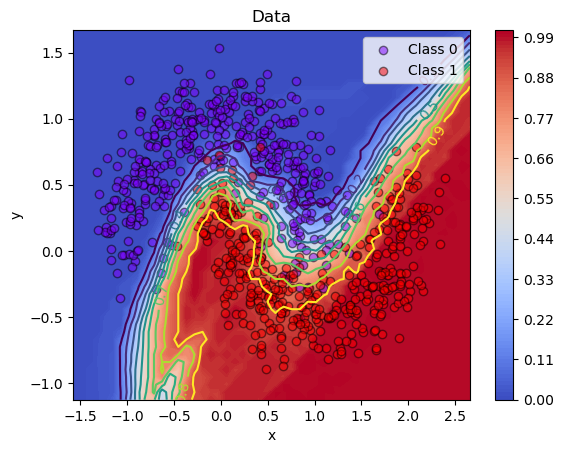

In [27]:
plot_decision_region(X, gen_pred_fun_mem(mkdm_model))
plot_data(X_train, y_train)


The performance is much better. We can fine tune the sigma parameter.

In [28]:

# train the classifier
mkdm_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])
print(f"Initial sigma: {mkdm_model.kernel.sigma.numpy()}")
mkdm_model.fit(X_train_ds, epochs=5, verbose=1)
print(f"FInal sigma: {mkdm_model.kernel.sigma.numpy()}")


Initial sigma: 0.48426368832588196
Epoch 1/5


/Users/fgonza/miniforge3/envs/tf2/lib/python3.11/site-packages/keras_core/src/optimizers/base_optimizer.py:412: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - categorical_accuracy: 0.9549 - loss: 0.1371
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9549 - loss: 0.1370 
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9549 - loss: 0.1370  
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9549 - loss: 0.1369 
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.9549 - loss: 0.1368  
FInal sigma: 0.566676676273346


Test loss: 0.12262928485870361
Test accuracy: 0.953125
Accuracy: 0.95
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
0.0 0.0


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_68046/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


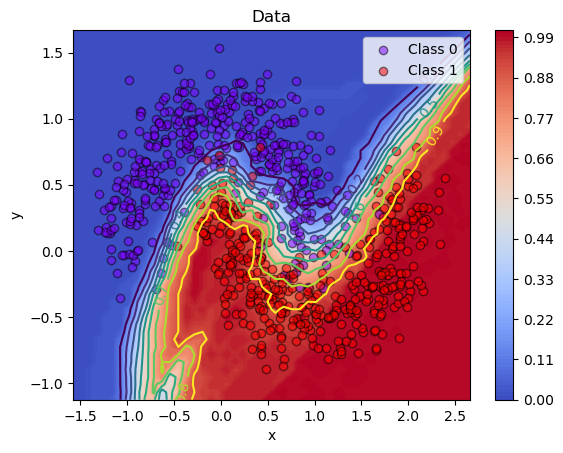

In [29]:
from sklearn.metrics import accuracy_score
score = mkdm_model.evaluate(X_test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

pred_y = mkdm_model.predict(X_pred_ds, verbose=0)
pred_y = np.argmax(pred_y, axis=1)
print("Accuracy: {}".format(accuracy_score(y_test, pred_y)))

plot_decision_region(X, gen_pred_fun_mem(mkdm_model))
plot_data(X_train, y_train)


## MNIST example

An example using the mnist dataset. In addition to perform classification we will show how to perform generation.

In [30]:
from sklearn.model_selection import train_test_split
import numpy as np
from keras_core.layers import Input, Dense
from keras_core.models import Model
from keras_core import optimizers
from keras_core import losses
from keras_core import metrics
import kdm

from importlib import reload


In [32]:
# Create a dataset from mnist using tf
#(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


# reshape the data to include a channel dimension
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Partition the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
      x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
      fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
      axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
      axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()


We define a deep encoder that will be used to map input images to a low-dimensional latent space.

In [33]:
tfkl = keras.layers

def create_encoder(input_shape, base_depth, encoded_size):
    encoder = keras.Sequential([
        tfkl.InputLayer(shape=input_shape),
        tfkl.Lambda(lambda x: x - 0.5),
        tfkl.Conv2D(base_depth, 5, strides=1,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(base_depth, 5, strides=2,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=1,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=2,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                    padding='valid', activation=keras.ops.leaky_relu),
        tfkl.Dense(encoded_size,
                activation=None),#, activity_regularizer=tf.keras.regularizers.l2(1e-3)),
        #tfkl.layers.LayerNormalization(),
        tfkl.Flatten(),
    ])
    return encoder

The classifier model (QKMClassModel) receives as input the encoder, and applies it before applying the QKM inference layer.

In [34]:
# Define the encoder
input_shape = (28, 28, 1)
base_depth = 32
encoded_size = 16
encoder1 = create_encoder(input_shape, base_depth, encoded_size)

# warm up the encoder
enc_model = keras.Sequential([encoder1,
                keras.layers.Dense(10, activation='softmax')])
enc_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                loss=losses.sparse_categorical_crossentropy,
                metrics=[metrics.sparse_categorical_accuracy])
enc_model.fit(X_train, y_train, epochs=1, batch_size=128)

score = enc_model.evaluate(X_test, y_test, verbose=0)
print('Base encoder test loss:', score[0])
print('Base encoder test accuracy:', score[1])
score = enc_model.evaluate(X_train, y_train, verbose=0)
print('Base encoder train loss:', score[0])
print('Base encoder train accuracy:', score[1])


# Create a classifier model
dim_y = 10
n_comp = 64

kdm_mnist = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder1,
                            n_comp=n_comp,        
                            sigma=0.1)

# initialize the prototypes using random samples from the training set
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_mnist.init_components(X_train[idx], keras.ops.one_hot(y_train[idx], 10), 
                          init_sigma=True, sigma_mult=0.1)

print(f'Sigma: {kdm_mnist.kernel.sigma.numpy()}')

# Compile the model
kdm_mnist.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

# Evaluate the classifier
score = kdm_mnist.evaluate(X_test, y_test, verbose=0)
print('KDM test loss:', score[0])
print('KDM test accuracy:', score[1])
score = kdm_mnist.evaluate(X_train, y_train, verbose=0)
print('KDM train loss:', score[0])
print('KDM train accuracy:', score[1])
print(f'Sigma: {kdm_mnist.kernel.sigma.numpy()}')

375/375 ━━━━━━━━━━━━━━━━━━━━ 37s 92ms/step - loss: 0.7387 - sparse_categorical_accuracy: 0.7269
Base encoder test loss: 0.37542250752449036
Base encoder test accuracy: 0.8622999787330627
Base encoder train loss: 0.3447001874446869
Base encoder train accuracy: 0.8754791617393494
Sigma: 1.630044937133789
KDM test loss: 1.2995355129241943
KDM test accuracy: 0.6517000198364258
KDM train loss: 1.2854446172714233
KDM train accuracy: 0.6569791436195374
Sigma: 1.630044937133789


In [35]:
# create callbacks
from keras_core.callbacks import ModelCheckpoint, EarlyStopping
earlystop = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5,
                           verbose=1, restore_best_weights=True)

# Train the model
kdm_mnist.fit(X_train, y_train, validation_data=(X_val, y_val), 
              epochs=20, batch_size=128, verbose=1,
              callbacks=[earlystop])
print(f'Final Sigma: {kdm_mnist.kernel.sigma.numpy()}')


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 49s 117ms/step - loss: 0.7342 - sparse_categorical_accuracy: 0.7933 - val_loss: 0.4749 - val_sparse_categorical_accuracy: 0.8605
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 35s 93ms/step - loss: 0.4134 - sparse_categorical_accuracy: 0.8749 - val_loss: 0.3609 - val_sparse_categorical_accuracy: 0.8861
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - loss: 0.3166 - sparse_categorical_accuracy: 0.8957 - val_loss: 0.3257 - val_sparse_categorical_accuracy: 0.8913
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - loss: 0.2769 - sparse_categorical_accuracy: 0.9062 - val_loss: 0.2848 - val_sparse_categorical_accuracy: 0.9023
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - loss: 0.2333 - sparse_categorical_accuracy: 0.9194 - val_loss: 0.2821 - val_sparse_categorical_accuracy: 0.9038
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - loss: 0.2097 - sparse_categorical_accuracy: 0.9263 - val_loss: 0.2920 - val_sparse_categorical_accuracy

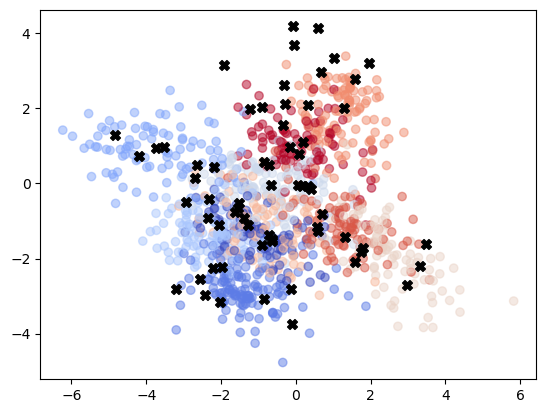

In [38]:
import matplotlib.pyplot as plt
# Visualize the points in the feature space
plt.scatter(encoder1(X_train[:1000])[:, 0], encoder1(X_train[:1000])[:, 1], alpha=0.5, c=y_train[:1000], cmap=plt.cm.coolwarm)

# plot the prototypes
plt.scatter(kdm_mnist.kdm.c_x.numpy()[:, 0], kdm_mnist.kdm.c_x.numpy()[:, 1], c='k', marker='X', s=50)
plt.show()

The figure above show training samples mapped to the latent space with different colors according to the class. The prototypes are shown as black crosses. Note that the prototypes do not cover all the areas of the different classes in the latent space, rather they are positioned to maximize the classification performance.

In [39]:
# Evaluate the classifier
score = kdm_mnist.evaluate(X_test, y_test, verbose=0)
print('KDM Test loss:', score[0])
print('KDM Test accuracy:', score[1])
score = kdm_mnist.evaluate(X_train, y_train, verbose=0)
print('KDM Train loss:', score[0])
print('KDM Train accuracy:', score[1])
print(f'KDM Sigma: {kdm_mnist.kernel.sigma.numpy()}')

QKM Test loss: 0.26871055364608765
QKM Test accuracy: 0.91839998960495
QKM Train loss: 0.0879344716668129
QKM Train accuracy: 0.971666693687439
QKM Sigma: 2.5751571655273438


Now we will train a density estimation model using the QKMJointDenEstModel class and keeping the encoder fix. This model maximizes the joint likelihood of inputs and outputs. The goal is to obtain more representative prototypes, since the prototypes learned using the classification model are not representative of the data distribution, since them are optimized to maximize the classification accuracy.

In [42]:
n_comp = 300
encoder2 = create_encoder(input_shape, base_depth, encoded_size)
encoder2.set_weights(encoder1.get_weights())

mkdm_model = MemKDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder2,
                            n_comp=n_comp,
                            sigma=kdm_mnist.kernel.sigma.numpy())

# init the memory
mkdm_model.create_index(X_train, np.eye(10)[y_train])
X_train_ds = mkdm_model.create_train_ds(batch_size=32)
X_test_ds = mkdm_model.create_test_ds(X_test, np.eye(10)[y_test], batch_size=32)
X_pred_ds = mkdm_model.create_predict_ds(X_test)

mkdm_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step


In [47]:
scores = []
mult = [2 ** i for i in range(-3, 7, 1)]
for m in mult:
    mkdm_model.kernel.sigma.assign(kdm_mnist.kernel.sigma.numpy() * m)
    score = mkdm_model.evaluate(X_test_ds, verbose=0)
    print(mkdm_model.kernel.sigma.numpy())
    print('Mem QKM Test loss:', score[0])
    print('Mem QKM Test accuracy:', score[1])
    scores.append(score)


0.32189465
Mem QKM Test loss: 0.28388237953186035
Mem QKM Test accuracy: 0.9182692170143127
0.6437893
Mem QKM Test loss: 0.28388237953186035
Mem QKM Test accuracy: 0.9182692170143127
1.2875786
Mem QKM Test loss: 0.28388237953186035
Mem QKM Test accuracy: 0.9182692170143127
2.5751572
Mem QKM Test loss: 0.28388237953186035
Mem QKM Test accuracy: 0.9182692170143127
5.1503143
Mem QKM Test loss: 0.28383901715278625
Mem QKM Test accuracy: 0.9182692170143127
10.300629
Mem QKM Test loss: 0.285434365272522
Mem QKM Test accuracy: 0.9177684187889099
20.601257
Mem QKM Test loss: 0.2896343171596527
Mem QKM Test accuracy: 0.9164663553237915
41.202515
Mem QKM Test loss: 0.3009767532348633
Mem QKM Test accuracy: 0.9141626358032227
82.40503
Mem QKM Test loss: 0.28758588433265686
Mem QKM Test accuracy: 0.9162660241127014
164.81006
Mem QKM Test loss: 0.2833651602268219
Mem QKM Test accuracy: 0.9180688858032227


In [49]:
import tensorflow as tf
X_pred_ds[0].shape, X_pred_ds[1].shape
neigh_x =  tf.gather(mkdm_model.samples_x, X_pred_ds[1], axis=0)
# Calculate the distance between the query and the neighbors
dist = tf.norm(X_pred_ds[0][:, tf.newaxis, :] - neigh_x, axis=2)
# Calculate the average, min and max distance
avg_dist = tf.reduce_mean(dist, axis=1)
min_dist = tf.reduce_min(dist, axis=1)
max_dist = tf.reduce_max(dist, axis=1)
# plot a histogram of the distances


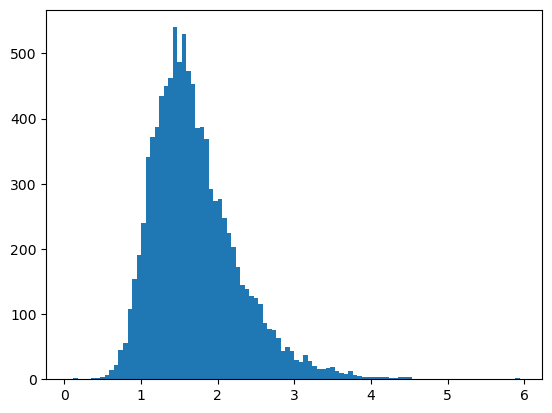

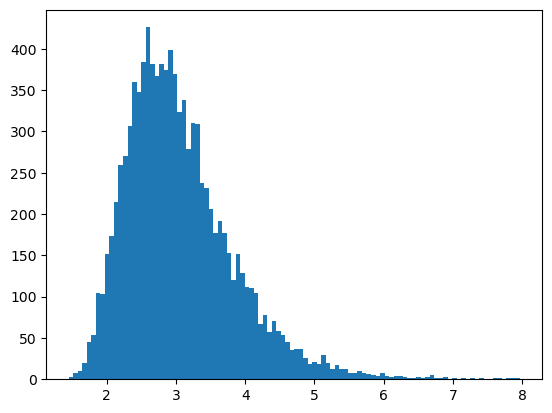

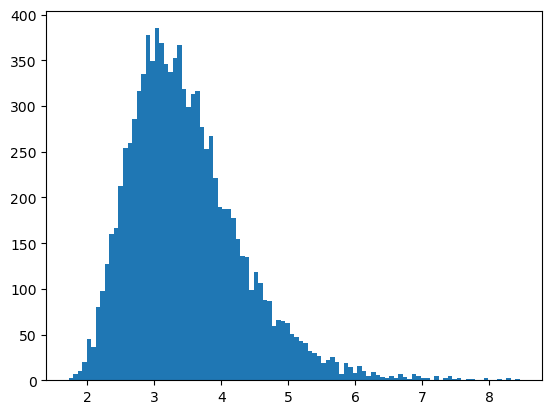

In [50]:
import matplotlib.pyplot as plt
plt.hist(min_dist.numpy(), bins=100)
plt.show()

plt.hist(avg_dist.numpy(), bins=100)
plt.show()

plt.hist(max_dist.numpy(), bins=100)
plt.show()


In [16]:

mqkm_model.kernel.sigma.assign(5)
mqkm_model.predict((X_pred_ds[0][0:2], X_pred_ds[1][0:2]) ,  verbose=0)

2023-08-23 15:31:27.852475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.9999999],
       [0.       , 0.       , 1.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ]], dtype=float32)

In [17]:
X_pred_ds[0].shape, X_pred_ds[1].shape

(TensorShape([10000, 16]), TensorShape([10000, 300]))

In [18]:
from qkm.tf.layers import MemRBFKernelLayer, MemQKMLayer, RBFKernelLayer


mrbfk = MemRBFKernelLayer(sigma=0.5, dim=64)
rbfk = RBFKernelLayer(sigma=0.5, dim=64)
mqkm = MemQKMLayer(kernel=mrbfk, dim_x=64, dim_y=1, n_comp=200)

x_enc, neighbors = X_pred_ds[0][:20], X_pred_ds[1][:20]
x_neigh = tf.gather(mqkm_model.samples_x, neighbors, axis=0)
y_neigh = tf.gather(mqkm_model.samples_y, neighbors, axis=0)
rho_y = mqkm([x_enc, x_neigh, y_neigh])
print(rho_y[0, :10, 0])

tf.Tensor(
[0.03411194 0.03198439 0.02851921 0.0252539  0.0216475  0.0183493
 0.01620086 0.0136059  0.01352022 0.01349683], shape=(10,), dtype=float32)


In [19]:
in_v = tf.expand_dims(x_enc, axis=1) # shape (bs, 1, dim_x)
out_vw = mrbfk(in_v, x_neigh)
out_vw_1 = rbfk(in_v, x_neigh[0])
print (out_vw.shape)
print(out_vw[0,0,:10] ** 2)
print(out_vw_1[0,0,:10] ** 2)

(20, 1, 300)
tf.Tensor(
[0.45210585 0.42390808 0.3779821  0.33470502 0.28690717 0.2431942
 0.21471964 0.1803271  0.17919157 0.1788815 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.45210585 0.42391136 0.3779821  0.33470502 0.28690502 0.24319604
 0.214718   0.1803285  0.17918883 0.17888285], shape=(10,), dtype=float32)


In [20]:
np.sum(y_neigh,axis=1)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 300.],
       [  0.,   0., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  3.,   0.,   0.,   0.,   0.,   0., 297.,   0.,   0.,   0.],
       [  0., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 300.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 300.,   0.,   0.],
       [  0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 213.,   0.,  84.,   3.,   0.],
       [  0.,   0.,   0., 300.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  85.,   0., 21

In [21]:
print(y_neigh[8, :10])

tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)


In [53]:
qkm_mnist.kernel.sigma.assign(5)
qkm_mnist.predict(X_test[:2], verbose=0)

array([[1.14879615e-04, 5.51695994e-05, 7.83121504e-05, 6.73886680e-05,
        6.80981902e-05, 7.99595437e-05, 1.33094436e-04, 9.99308944e-01,
        4.09124877e-05, 5.33210768e-05],
       [6.11804790e-05, 2.23394691e-05, 9.99747813e-01, 1.04540923e-05,
        5.60874978e-05, 5.71921191e-06, 4.64761761e-05, 2.53393737e-05,
        2.52210566e-06, 2.21634091e-05]], dtype=float32)

In [48]:
# train the classifier
mkdm_model.kernel.sigma.assign(kdm_mnist.kernel.sigma.numpy())
mkdm_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])
print(f"Initial sigma: {mkdm_model.kernel.sigma.numpy()}")
mkdm_model.fit(X_train_ds, epochs=2, verbose=1)
print(f"FInal sigma: {mkdm_model.kernel.sigma.numpy()}")


Initial sigma: 2.5751571655273438
Epoch 1/2


/Users/fgonza/miniforge3/envs/tf2/lib/python3.11/site-packages/keras_core/src/optimizers/base_optimizer.py:412: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - categorical_accuracy: 0.9725 - loss: 0.0996
Epoch 2/2
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - categorical_accuracy: 0.9725 - loss: 0.0996
FInal sigma: 2.5751571655273438


In [45]:
score = mkdm_model.evaluate(X_test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Test loss: 0.28388237953186035
Test accuracy: 0.9182692170143127


In [34]:
encoder2.set_weights(encoder1.get_weights())


In [34]:
neighbors =  X_pred_ds[1]
y_neigh = tf.gather(mqkm_model.samples_y, neighbors, axis=0)
y_pred = np.argmax(y_neigh, axis=1)
y_neigh.shape

TensorShape([10000, 300, 10])

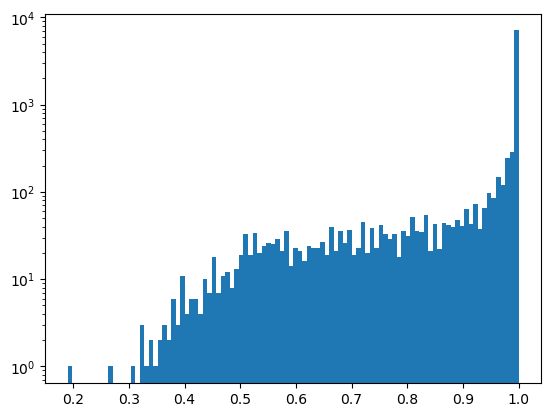

In [29]:
y_avg = np.mean(y_neigh, axis=1)
plt.hist(np.max(y_avg, axis=1), bins=100, log=True);

In [35]:
from sklearn.metrics import accuracy_score  
y_pred = np.argmax(y_avg, axis=1)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.9054
